In [1]:
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import numpy as np
from PIL import Image
# import polars as pd
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import random
import timeit
from tqdm import tqdm

In [ ]:
RANDOM_SEED = 42
BATCH_SIZE = 512
EPOCHS = 40
LEARNING_RATE = 1e-4
NUM_CLASSES = 10
PATCH_SIZE = 4
IMG_SIZE = 28
IN_CHANNELS = 1
NUM_HEADS = 8
DROPOUT = 0.001
HIDDEN_DIM = 768
ADAM_WEIGHT_DECAY = 0
ADAM_BETAS = (0.9, 0.999)
ACTIVATION = 'gelu'
NUM_ENCODERS = 4
EMBED_DIM = (PATCH_SIZE**2) * IN_CHANNELS # 16
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2 # 49
USE_SPECTRE=True

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = 'cuda' if torch.cuda.is_available() else 'cpu'



In [3]:
from vit import PatchEmbedding, ViT

# Test PatchEmbedding
model = PatchEmbedding(EMBED_DIM, PATCH_SIZE, NUM_PATCHES, DROPOUT, IN_CHANNELS).to(device)
x = torch.randn(512, 1, 28, 28).to(device)
print(model(x).shape)


torch.Size([512, 50, 16])


In [4]:
# Test ViT
# model = ViT(IMG_SIZE, NUM_CLASSES, PATCH_SIZE, EMBED_DIM, NUM_ENCODERS, NUM_HEADS, HIDDEN_DIM, DROPOUT, ACTIVATION, IN_CHANNELS).to(device)
model = ViT(img_size=IMG_SIZE, patch_size=PATCH_SIZE, in_channels=IN_CHANNELS, 
            num_classes=NUM_CLASSES, embed_dim=EMBED_DIM, num_encoders=NUM_ENCODERS, 
            num_heads=NUM_HEADS, hidden_dim=HIDDEN_DIM, dropout=DROPOUT, activation=ACTIVATION,
            use_spectre=USE_SPECTRE).to(device)
x = torch.randn(512, 1, 28, 28).to(device)
print(model(x).shape)

# Print model params number
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

model.state_dict()


torch.Size([512, 10])
107338


OrderedDict([('embeddings_block.cls_token',
              tensor([[[-1.2086, -1.8661,  0.5116,  0.4599,  1.2298,  0.9193, -1.0093,
                        -0.9849,  1.2345, -0.1707, -1.2076, -1.4823,  1.3224,  0.9230,
                        -2.1365, -0.0292]]], device='cuda:0')),
             ('embeddings_block.position_embeddings',
              tensor([[[ 1.4995e+00,  9.2261e-01, -1.7139e+00, -8.7663e-01, -6.5653e-01,
                         2.4439e-01, -6.7253e-02,  9.8845e-01,  7.9449e-01,  1.7440e+00,
                        -1.2546e+00,  7.6990e-04, -1.2492e-01,  7.0556e-01,  7.0240e-02,
                         5.6717e-01],
                       [ 2.3363e-02,  5.7220e-01, -1.9276e-01,  7.5349e-02,  1.1494e+00,
                        -2.0134e-02, -2.5483e+00,  2.2196e-01, -5.0568e-02, -2.1717e+00,
                        -5.1775e-01,  3.9987e-01,  7.8984e-01,  3.1630e-01,  9.5272e-02,
                         4.9544e-01],
                       [ 1.6751e-02, -1.1424e+00,  9.3

In [5]:
train_df = pd.read_csv("./data/train.csv")
test_df = pd.read_csv("./data/test.csv")
submission_df = pd.read_csv("./data/sample_submission.csv")

In [6]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
submission_df.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [9]:
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=RANDOM_SEED, shuffle=True)

In [10]:
class MNISTTrainDataset(Dataset):
    def __init__(self, images, labels, indicies):
        super().__init__()
        self.images = images
        self.labels = labels
        self.indicies = indicies
        self.transofrm = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        label = self.labels[idx]
        index = self.indicies[idx]
        
        image = self.transofrm(image)
        
        return {'image': image, 'label': label, 'index': index}
    

class MNISTValDataset(Dataset):
    def __init__(self, images, labels, indicies):
        super().__init__()
        self.images = images
        self.labels = labels
        self.indicies = indicies
        self.transofrm = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        label = self.labels[idx]
        index = self.indicies[idx]
        
        image = self.transofrm(image)
        
        return {'image': image, 'label': label, 'index': index}
       
class MNISTSubmitDataset(Dataset):
    def __init__(self, images, indicies):
        super().__init__()
        self.images = images
        self.indicies = indicies
        self.transofrm = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        index = self.indicies[idx]
        image = self.transofrm(image)
        
        return {'image': image, 'index': index}

37800
{'image': tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0

<Figure size 640x480 with 0 Axes>

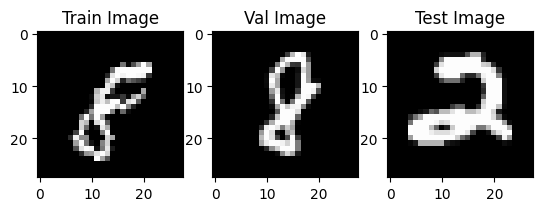

In [11]:
plt.figure()
f, axarr = plt.subplots(1, 3)

train_dataset = MNISTTrainDataset(train_df.iloc[:, 1:].values.astype(np.uint8), train_df.iloc[:, 0].values, train_df.index.values)
print(len(train_dataset))
print(train_dataset[0])
axarr[0].imshow(train_dataset[0]['image'].squeeze(), cmap='gray')
axarr[0].set_title("Train Image")
print("-"*30)

val_dataset = MNISTValDataset(val_df.iloc[:, 1:].values.astype(np.uint8), val_df.iloc[:, 0].values, val_df.index.values)
print(len(val_dataset))
print(val_dataset[0])
axarr[1].imshow(val_dataset[0]['image'].squeeze(), cmap='gray')
axarr[1].set_title("Val Image")
print("-"*30)

test_dataset = MNISTSubmitDataset(test_df.values.astype(np.uint8), test_df.index.values)
print(len(test_dataset))
print(test_dataset[0])
axarr[2].imshow(test_dataset[0]['image'].squeeze(), cmap='gray')
axarr[2].set_title("Test Image")
print("-"*30)

In [12]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [13]:
use_amp = True

criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)
optimizer = optim.AdamW(model.parameters(), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)
scaler = torch.amp.GradScaler("cuda" ,enabled=use_amp)
start = timeit.default_timer()
for epoch in tqdm(range(EPOCHS), position=0, leave=True):
    model.train()
    train_labels = []
    train_preds = []
    train_running_loss = 0
    for idx, img_label in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = img_label["image"].float().to(device)
        label = img_label["label"].type(torch.uint8).to(device)
        with torch.autocast(device_type=device, dtype=torch.float16, enabled=use_amp):
            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim=1)
            
            train_labels.extend(label.cpu().detach())
            train_preds.extend(y_pred_label.cpu().detach())

            loss = criterion(y_pred, label)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        # optimizer.step()

        train_running_loss += loss.item()

    train_loss = train_running_loss / (idx + 1)
    
    model.eval()
    val_labels = []
    val_preds = []
    val_running_loss = 0
    with torch.no_grad():
        for idx, img_label in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = img_label["image"].float().to(device)
            label = img_label["label"].type(torch.uint8).to(device)
            
            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim=1)

            val_labels.extend(label.cpu().detach())
            val_preds.extend(y_pred_label.cpu().detach())

            loss = criterion(y_pred, label)
            val_running_loss += loss.item()
            
    
        val_loss = val_running_loss /  (idx + 1)
    
    print("-"*30)
    print(f"Train Loss EPOCH {epoch + 1}: {train_loss:.4f}")
    print(f"Val Loss EPOCH {epoch + 1}: {val_loss:.4f}")
    print(f"Train Accuracy EPOCH {epoch + 1}: {sum(1 for x, y in zip(train_preds, train_labels) if x == y) / len(train_labels):.4f}")
    print(f"Val Accuracy EPOCH {epoch + 1}: {sum(1 for x, y in zip(val_preds, val_labels) if x == y) / len(val_labels):.4f}")
    print("-"*30)

    
stop = timeit.default_timer()
print(f"Training time: {stop - start:.2f}")

  2%|▎         | 1/40 [00:08<05:46,  8.88s/it]

------------------------------
Train Loss EPOCH 1: 2.2930
Val Loss EPOCH 1: 2.2252
Train Accuracy EPOCH 1: 0.1352
Val Accuracy EPOCH 1: 0.1679
------------------------------


  5%|▌         | 2/40 [00:17<05:34,  8.79s/it]

------------------------------
Train Loss EPOCH 2: 2.0640
Val Loss EPOCH 2: 1.8725
Train Accuracy EPOCH 2: 0.2628
Val Accuracy EPOCH 2: 0.3764
------------------------------


  8%|▊         | 3/40 [00:26<05:25,  8.80s/it]

------------------------------
Train Loss EPOCH 3: 1.7998
Val Loss EPOCH 3: 1.6339
Train Accuracy EPOCH 3: 0.4061
Val Accuracy EPOCH 3: 0.4810
------------------------------


 10%|█         | 4/40 [00:34<05:13,  8.70s/it]

------------------------------
Train Loss EPOCH 4: 1.6404
Val Loss EPOCH 4: 1.4958
Train Accuracy EPOCH 4: 0.4835
Val Accuracy EPOCH 4: 0.5481
------------------------------


 12%|█▎        | 5/40 [00:43<05:02,  8.64s/it]

------------------------------
Train Loss EPOCH 5: 1.5307
Val Loss EPOCH 5: 1.3974
Train Accuracy EPOCH 5: 0.5339
Val Accuracy EPOCH 5: 0.6160
------------------------------


 15%|█▌        | 6/40 [00:52<04:54,  8.67s/it]

------------------------------
Train Loss EPOCH 6: 1.4292
Val Loss EPOCH 6: 1.2855
Train Accuracy EPOCH 6: 0.5823
Val Accuracy EPOCH 6: 0.6729
------------------------------


 18%|█▊        | 7/40 [01:00<04:44,  8.62s/it]

------------------------------
Train Loss EPOCH 7: 1.3310
Val Loss EPOCH 7: 1.1701
Train Accuracy EPOCH 7: 0.6272
Val Accuracy EPOCH 7: 0.7055
------------------------------


 20%|██        | 8/40 [01:09<04:36,  8.65s/it]

------------------------------
Train Loss EPOCH 8: 1.2384
Val Loss EPOCH 8: 1.1075
Train Accuracy EPOCH 8: 0.6644
Val Accuracy EPOCH 8: 0.7333
------------------------------


 22%|██▎       | 9/40 [01:17<04:26,  8.59s/it]

------------------------------
Train Loss EPOCH 9: 1.1620
Val Loss EPOCH 9: 1.0301
Train Accuracy EPOCH 9: 0.6901
Val Accuracy EPOCH 9: 0.7500
------------------------------


 25%|██▌       | 10/40 [01:26<04:16,  8.56s/it]

------------------------------
Train Loss EPOCH 10: 1.0833
Val Loss EPOCH 10: 0.9486
Train Accuracy EPOCH 10: 0.7126
Val Accuracy EPOCH 10: 0.7676
------------------------------


 28%|██▊       | 11/40 [01:35<04:08,  8.58s/it]

------------------------------
Train Loss EPOCH 11: 1.0177
Val Loss EPOCH 11: 0.8766
Train Accuracy EPOCH 11: 0.7312
Val Accuracy EPOCH 11: 0.7910
------------------------------


 30%|███       | 12/40 [01:43<03:59,  8.57s/it]

------------------------------
Train Loss EPOCH 12: 0.9508
Val Loss EPOCH 12: 0.8233
Train Accuracy EPOCH 12: 0.7488
Val Accuracy EPOCH 12: 0.8045
------------------------------


 32%|███▎      | 13/40 [01:52<03:53,  8.63s/it]

------------------------------
Train Loss EPOCH 13: 0.9022
Val Loss EPOCH 13: 0.7720
Train Accuracy EPOCH 13: 0.7582
Val Accuracy EPOCH 13: 0.8193
------------------------------


 35%|███▌      | 14/40 [02:00<03:43,  8.59s/it]

------------------------------
Train Loss EPOCH 14: 0.8500
Val Loss EPOCH 14: 0.7261
Train Accuracy EPOCH 14: 0.7739
Val Accuracy EPOCH 14: 0.8317
------------------------------


 38%|███▊      | 15/40 [02:09<03:34,  8.57s/it]

------------------------------
Train Loss EPOCH 15: 0.8013
Val Loss EPOCH 15: 0.6772
Train Accuracy EPOCH 15: 0.7860
Val Accuracy EPOCH 15: 0.8379
------------------------------


 40%|████      | 16/40 [02:18<03:26,  8.60s/it]

------------------------------
Train Loss EPOCH 16: 0.7627
Val Loss EPOCH 16: 0.6394
Train Accuracy EPOCH 16: 0.7961
Val Accuracy EPOCH 16: 0.8429
------------------------------


 42%|████▎     | 17/40 [02:26<03:17,  8.60s/it]

------------------------------
Train Loss EPOCH 17: 0.7316
Val Loss EPOCH 17: 0.6059
Train Accuracy EPOCH 17: 0.8031
Val Accuracy EPOCH 17: 0.8526
------------------------------


 45%|████▌     | 18/40 [02:35<03:10,  8.65s/it]

------------------------------
Train Loss EPOCH 18: 0.6929
Val Loss EPOCH 18: 0.5691
Train Accuracy EPOCH 18: 0.8123
Val Accuracy EPOCH 18: 0.8590
------------------------------


 48%|████▊     | 19/40 [02:43<03:01,  8.62s/it]

------------------------------
Train Loss EPOCH 19: 0.6590
Val Loss EPOCH 19: 0.5452
Train Accuracy EPOCH 19: 0.8236
Val Accuracy EPOCH 19: 0.8638
------------------------------


 50%|█████     | 20/40 [02:52<02:52,  8.62s/it]

------------------------------
Train Loss EPOCH 20: 0.6309
Val Loss EPOCH 20: 0.5088
Train Accuracy EPOCH 20: 0.8279
Val Accuracy EPOCH 20: 0.8700
------------------------------


 52%|█████▎    | 21/40 [03:01<02:44,  8.66s/it]

------------------------------
Train Loss EPOCH 21: 0.5989
Val Loss EPOCH 21: 0.5036
Train Accuracy EPOCH 21: 0.8364
Val Accuracy EPOCH 21: 0.8740
------------------------------


 55%|█████▌    | 22/40 [03:09<02:35,  8.64s/it]

------------------------------
Train Loss EPOCH 22: 0.5797
Val Loss EPOCH 22: 0.4901
Train Accuracy EPOCH 22: 0.8407
Val Accuracy EPOCH 22: 0.8805
------------------------------


 57%|█████▊    | 23/40 [03:18<02:27,  8.69s/it]

------------------------------
Train Loss EPOCH 23: 0.5492
Val Loss EPOCH 23: 0.4648
Train Accuracy EPOCH 23: 0.8477
Val Accuracy EPOCH 23: 0.8831
------------------------------


 60%|██████    | 24/40 [03:27<02:18,  8.66s/it]

------------------------------
Train Loss EPOCH 24: 0.5387
Val Loss EPOCH 24: 0.4557
Train Accuracy EPOCH 24: 0.8500
Val Accuracy EPOCH 24: 0.8840
------------------------------


 62%|██████▎   | 25/40 [03:35<02:09,  8.63s/it]

------------------------------
Train Loss EPOCH 25: 0.5144
Val Loss EPOCH 25: 0.4264
Train Accuracy EPOCH 25: 0.8588
Val Accuracy EPOCH 25: 0.8917
------------------------------


 65%|██████▌   | 26/40 [03:44<02:01,  8.68s/it]

------------------------------
Train Loss EPOCH 26: 0.4977
Val Loss EPOCH 26: 0.4172
Train Accuracy EPOCH 26: 0.8616
Val Accuracy EPOCH 26: 0.8869
------------------------------


 68%|██████▊   | 27/40 [03:53<01:52,  8.65s/it]

------------------------------
Train Loss EPOCH 27: 0.4823
Val Loss EPOCH 27: 0.3870
Train Accuracy EPOCH 27: 0.8640
Val Accuracy EPOCH 27: 0.8952
------------------------------


 70%|███████   | 28/40 [04:02<01:44,  8.68s/it]

------------------------------
Train Loss EPOCH 28: 0.4681
Val Loss EPOCH 28: 0.3971
Train Accuracy EPOCH 28: 0.8670
Val Accuracy EPOCH 28: 0.8948
------------------------------


 72%|███████▎  | 29/40 [04:10<01:35,  8.65s/it]

------------------------------
Train Loss EPOCH 29: 0.4581
Val Loss EPOCH 29: 0.3747
Train Accuracy EPOCH 29: 0.8712
Val Accuracy EPOCH 29: 0.8967
------------------------------


 75%|███████▌  | 30/40 [04:19<01:26,  8.63s/it]

------------------------------
Train Loss EPOCH 30: 0.4445
Val Loss EPOCH 30: 0.3552
Train Accuracy EPOCH 30: 0.8728
Val Accuracy EPOCH 30: 0.9002
------------------------------


 78%|███████▊  | 31/40 [04:27<01:18,  8.67s/it]

------------------------------
Train Loss EPOCH 31: 0.4327
Val Loss EPOCH 31: 0.3570
Train Accuracy EPOCH 31: 0.8742
Val Accuracy EPOCH 31: 0.8974
------------------------------


 80%|████████  | 32/40 [04:36<01:09,  8.65s/it]

------------------------------
Train Loss EPOCH 32: 0.4218
Val Loss EPOCH 32: 0.3558
Train Accuracy EPOCH 32: 0.8793
Val Accuracy EPOCH 32: 0.9040
------------------------------


 82%|████████▎ | 33/40 [04:45<01:00,  8.63s/it]

------------------------------
Train Loss EPOCH 33: 0.4151
Val Loss EPOCH 33: 0.3473
Train Accuracy EPOCH 33: 0.8797
Val Accuracy EPOCH 33: 0.9029
------------------------------


 85%|████████▌ | 34/40 [04:53<00:51,  8.66s/it]

------------------------------
Train Loss EPOCH 34: 0.4134
Val Loss EPOCH 34: 0.3346
Train Accuracy EPOCH 34: 0.8811
Val Accuracy EPOCH 34: 0.9064
------------------------------


 88%|████████▊ | 35/40 [05:02<00:43,  8.65s/it]

------------------------------
Train Loss EPOCH 35: 0.3984
Val Loss EPOCH 35: 0.3252
Train Accuracy EPOCH 35: 0.8836
Val Accuracy EPOCH 35: 0.9055
------------------------------


 90%|█████████ | 36/40 [05:11<00:34,  8.71s/it]

------------------------------
Train Loss EPOCH 36: 0.3869
Val Loss EPOCH 36: 0.3261
Train Accuracy EPOCH 36: 0.8868
Val Accuracy EPOCH 36: 0.9083
------------------------------


 92%|█████████▎| 37/40 [05:19<00:26,  8.69s/it]

------------------------------
Train Loss EPOCH 37: 0.3808
Val Loss EPOCH 37: 0.3080
Train Accuracy EPOCH 37: 0.8884
Val Accuracy EPOCH 37: 0.9102
------------------------------


 95%|█████████▌| 38/40 [05:28<00:17,  8.68s/it]

------------------------------
Train Loss EPOCH 38: 0.3748
Val Loss EPOCH 38: 0.3169
Train Accuracy EPOCH 38: 0.8909
Val Accuracy EPOCH 38: 0.9076
------------------------------


 98%|█████████▊| 39/40 [05:37<00:08,  8.73s/it]

------------------------------
Train Loss EPOCH 39: 0.3646
Val Loss EPOCH 39: 0.3243
Train Accuracy EPOCH 39: 0.8916
Val Accuracy EPOCH 39: 0.9067
------------------------------


100%|██████████| 40/40 [05:46<00:00,  8.65s/it]

------------------------------
Train Loss EPOCH 40: 0.3583
Val Loss EPOCH 40: 0.2999
Train Accuracy EPOCH 40: 0.8950
Val Accuracy EPOCH 40: 0.9131
------------------------------
Training time: 346.16


In [14]:
torch.cuda.empty_cache()

In [15]:
labels = []
ids = []
imgs = []
model.eval()

with torch.no_grad():
    for idx, sample in enumerate(tqdm(test_dataloader, position=0, leave=True)):
        img = sample["image"].to(device)
        ids.extend([int(i) + 1 for i in sample["index"]])
        
        outputs = model(img)
        imgs.extend(img.detach().cpu())
        labels.extend([int(i) for i in torch.argmax(outputs, dim=1)])
        

100%|██████████| 55/55 [00:02<00:00, 21.30it/s]


<Figure size 640x480 with 0 Axes>

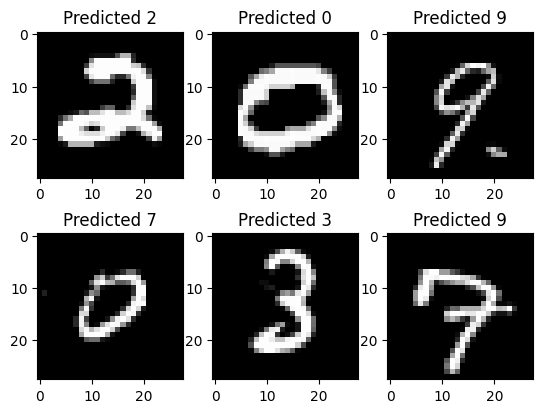

In [16]:
plt.figure()
f, axarr = plt.subplots(2, 3)
counter = 0
for i in range(2):
    for j in range(3):
        axarr[i][j].imshow(imgs[counter].squeeze(), cmap='gray')
        axarr[i][j].set_title(f"Predicted {labels[counter]}")
        counter += 1
        
plt.show()